In [1]:
!pip -q install biopython scikit-learn imageio

import os, io, gzip, math, shutil, glob, json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import imageio

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

print('TensorFlow:', tf.__version__)

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Output dirs
os.makedirs('outputs/figures', exist_ok=True)
os.makedirs('outputs/gifs', exist_ok=True)
os.makedirs('data', exist_ok=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.6 MB/s eta 0:00:00
TensorFlow: 2.19.0


In [2]:
from Bio import Entrez, SeqIO

# 👉 Replace with your email to comply with NCBI usage policy
Entrez.email = "masudurrabby8@gmail.com"  # REQUIRED by NCBI

# Example queries for diversity by length and keywords
queries = [
    "kinase[Title] AND 100:200[SLEN]",
    "transcription factor[Title] AND 50:120[SLEN]",
    "membrane protein[Title] AND 200:400[SLEN]",
    "enzyme[Title] AND 80:150[SLEN]",
]

all_records = []
for q in queries:
    handle = Entrez.esearch(db="protein", term=q, retmax=50)
    result = Entrez.read(handle)
    ids = result.get('IdList', [])
    if not ids:
        continue
    fetch = Entrez.efetch(db="protein", id=ids, rettype="fasta", retmode="text")
    records = list(SeqIO.parse(fetch, "fasta"))
    all_records.extend(records)

# Deduplicate by ID
uniq = {r.id: r for r in all_records}

fasta_path = 'data/ncbi_sequences.fasta'
SeqIO.write(list(uniq.values()), fasta_path, "fasta")
print(f"Saved {len(uniq)} sequences to {fasta_path}")

Saved 200 sequences to data/ncbi_sequences.fasta


In [3]:
import urllib.request

Z_CULL = "https://zenodo.org/records/7764556/files/cullpdb+profile_5926_filtered.npy.gz?download=1"
Z_CB513 = "https://zenodo.org/records/7764556/files/cb513+profile_split1.npy.gz?download=1"

paths = {
    'cull_filtered': 'data/cullpdb+profile_5926_filtered.npy.gz',
    'cb513': 'data/cb513+profile_split1.npy.gz',
}

for url, dest in [(Z_CULL, paths['cull_filtered']), (Z_CB513, paths['cb513'])]:
    if not os.path.exists(dest):
        print('Downloading', url)
        urllib.request.urlretrieve(url, dest)
    else:
        print('Already exists:', dest)

for k,v in paths.items():
    print(k, os.path.getsize(v)/1e9, 'GB')

cull_filtered 1.71250808 GB
cb513 0.16406888 GB


In [4]:


import numpy as np

MAXLEN = 700  # fixed sequence length

def load_array(path):
    """
    Load .npy file safely (even if created with Python 2).
    """
    arr = np.load(path, allow_pickle=True)
    return arr

def pad_or_truncate(arr, maxlen=MAXLEN):
    """
    Ensure every protein sequence has fixed length (maxlen).
    If shorter, pad with zeros. If longer, truncate.
    """
    num_samples = arr.shape[0]
    num_features = arr.shape[1] if arr.ndim > 1 else 1

    processed = []
    for i in range(num_samples):
        seq = arr[i]
        # Ensure seq is 2D (length × features)
        if seq.ndim == 1:
            seq = seq.reshape(-1, 1)
        if seq.shape[0] > maxlen:   # truncate
            seq = seq[:maxlen, :]
        elif seq.shape[0] < maxlen: # pad
            pad_len = maxlen - seq.shape[0]
            seq = np.vstack([seq, np.zeros((pad_len, seq.shape[1]))])
        processed.append(seq)

    return np.array(processed)

# Load CullPDB and CB513 datasets
cull = load_array("/content/data/cullpdb+profile_5926_filtered.npy.gz")
cb513 = load_array("/content/data/cb513+profile_split1.npy.gz")

print("Cull shape (before processing):", cull.shape)
print("CB513 shape (before processing):", cb513.shape)

# Fix sequence lengths
cull_fixed = pad_or_truncate(cull)
cb513_fixed = pad_or_truncate(cb513)

print("Cull fixed shape:", cull_fixed.shape)   # should be (N, 700, features)
print("CB513 fixed shape:", cb513_fixed.shape)


Cull shape (before processing): (5365, 39900)
CB513 shape (before processing): (514, 39900)
Cull fixed shape: (5365, 700, 1)
CB513 fixed shape: (514, 700, 1)


/tmp/ipython-input-3149097431.py:9: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  arr = np.load(path, allow_pickle=True)


In [5]:
# CullPDB dataset structure:
# [:, :, :57] → Input features
# [:, :, 57:65] → Secondary structure labels (Q8, one-hot encoded)

X_cull = cull_fixed[:, :, :57]
y_cull = cull_fixed[:, :, 57:65]

X_cb513 = cb513_fixed[:, :, :57]
y_cb513 = cb513_fixed[:, :, 57:65]

print("Cull X:", X_cull.shape, "Cull y:", y_cull.shape)
print("CB513 X:", X_cb513.shape, "CB513 y:", y_cb513.shape)


Cull X: (5365, 700, 1) Cull y: (5365, 700, 0)
CB513 X: (514, 700, 1) CB513 y: (514, 700, 0)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_cull, y_cull, test_size=0.1, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_cb513.shape, y_cb513.shape)  # CB513 used for testing


Train: (4828, 700, 1) (4828, 700, 0)
Val: (537, 700, 1) (537, 700, 0)
Test: (514, 700, 1) (514, 700, 0)


In [7]:
# ==========================================
# 1) Install & Imports
# ==========================================
!pip -q install biopython scikit-learn imageio

import os, shutil, glob, json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import imageio

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Create folders
os.makedirs('outputs/figures', exist_ok=True)
os.makedirs('outputs/gifs', exist_ok=True)
os.makedirs('data', exist_ok=True)


In [8]:
print(cull_fixed.shape, cb513_fixed.shape)
print(y_train.shape)

(5365, 700, 1) (514, 700, 1)
(4828, 700, 0)


In [9]:
import os

path = "/content/data/cullpdb+profile_5926_filtered.npy.gz"
print("File size (MB):", os.path.getsize(path)/1e6)


File size (MB): 1712.50808


In [10]:
# ==========================================
# 2) Load datasets (plain .npy files)
# ==========================================
cull_path = "/content/data/cullpdb+profile_5926_filtered.npy.gz"
cb_path   = "/content/data/cb513+profile_split1.npy.gz"

cull = np.load(cull_path, allow_pickle=True)
cb513 = np.load(cb_path, allow_pickle=True)

print("Cull shape (flattened):", cull.shape)
print("CB513 shape (flattened):", cb513.shape)


Cull shape (flattened): (5365, 39900)
CB513 shape (flattened): (514, 39900)


/tmp/ipython-input-2494841204.py:8: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  cb513 = np.load(cb_path, allow_pickle=True)


In [11]:
# ==========================================
# 3) Reshape flattened arrays
# ==========================================
def reshape_safe(arr, maxlen=700):
    # Number of complete sequences
    n_samples = arr.shape[0] // maxlen
    leftover = arr.shape[0] % maxlen

    if leftover != 0:
        # pad with zeros to make divisible
        pad_len = maxlen - leftover
        arr = np.vstack([arr, np.zeros((pad_len, arr.shape[1]))])
        n_samples += 1
    return arr.reshape(n_samples, maxlen, -1)

X_cull = reshape_safe(cull)
X_cb   = reshape_safe(cb513)

print("Cull reshaped:", X_cull.shape)
print("CB513 reshaped:", X_cb.shape)



Cull reshaped: (8, 700, 39900)
CB513 reshaped: (1, 700, 39900)


In [12]:
# ==========================================
# 4) Build features, labels, masks
# ==========================================
AA_ONEHOT = slice(0,22)
Q8_ALL    = slice(22,31)
Q8_ONLY   = slice(22,30)
PSSM      = slice(35,57)
USE_PSSM  = True

def build_xy(arr, use_pssm=True):
    aa = arr[:,:,AA_ONEHOT]
    y_all = arr[:,:,Q8_ALL]
    y = arr[:,:,Q8_ONLY]
    mask = 1.0 - y_all[:,:,-1]  # NoSeq mask
    if use_pssm:
        x = np.concatenate([aa[:,:,:-1], arr[:,:,PSSM]], axis=-1)
    else:
        x = aa[:,:,:-1]
    return x.astype('float32'), y.astype('float32'), mask.astype('float32')

X_all, Y_all, M_all = build_xy(X_cull)
X_test, Y_test, M_test = build_xy(X_cb)

# Train/validation split
idx = np.arange(X_all.shape[0])
train_idx, val_idx = train_test_split(idx, test_size=0.1, random_state=SEED)

X_train, Y_train, M_train = X_all[train_idx], Y_all[train_idx], M_all[train_idx]
X_val,   Y_val,   M_val   = X_all[val_idx],   Y_all[val_idx],   M_all[val_idx]

print("X_train:", X_train.shape, "Y_train:", Y_train.shape, "M_train:", M_train.shape)
print("X_val:", X_val.shape, "Y_val:", Y_val.shape, "M_val:", M_val.shape)
print("X_test:", X_test.shape, "Y_test:", Y_test.shape, "M_test:", M_test.shape)


X_train: (7, 700, 43) Y_train: (7, 700, 8) M_train: (7, 700)
X_val: (1, 700, 43) Y_val: (1, 700, 8) M_val: (1, 700)
X_test: (1, 700, 43) Y_test: (1, 700, 8) M_test: (1, 700)


In [13]:
# ==========================================
# 5) Build tf.data datasets
# ==========================================
BATCH = 16

def make_ds(X, Y, M, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, Y, M))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), seed=SEED)
    ds = ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(X_train, Y_train, M_train, shuffle=True)
val_ds   = make_ds(X_val,   Y_val,   M_val)
test_ds  = make_ds(X_test,  Y_test,  M_test)


In [14]:
# ==========================================
# 6) Define CNN + BiLSTM model
# ==========================================
F = X_train.shape[-1]

inp = layers.Input(shape=(MAXLEN, F))
x = layers.Conv1D(128, 7, padding='same', activation='relu')(inp)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv1D(64, 7, padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)

x = layers.TimeDistributed(layers.Dense(128, activation='relu'))(x)
out = layers.TimeDistributed(layers.Dense(8, activation='softmax'))(x)

model = models.Model(inp, out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 700, 43)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 700, 128)       │        38,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 700, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 700, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 700, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 700, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 700, 64)        │       114,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 700, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 700, 128)       │         8,320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 700, 8)         │         1,032 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,440 (1.63 MB)

 Trainable params: 426,184 (1.63 MB)

 Non-trainable params: 256 (1.00 KB)

In [15]:
# ==========================================
# 7) Train model
# ==========================================
EPOCHS = 30

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 114s 114s/step - accuracy: 0.1029 - loss: 1.9845 - val_accuracy: 1.0000 - val_loss: 1.8879
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.4443 - loss: 1.7980 - val_accuracy: 1.0000 - val_loss: 1.5397
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8041 - loss: 1.5775 - val_accuracy: 1.0000 - val_loss: 1.0625
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9263 - loss: 1.2979 - val_accuracy: 1.0000 - val_loss: 0.5097
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9482 - loss: 0.9297 - val_accuracy: 1.0000 - val_loss: 0.1177
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9510 - loss: 0.5634 - val_accuracy: 1.0000 - val_loss: 0.0102
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9516 - loss: 0.2636 - val_accuracy: 1.0000 - val_loss: 6.7265e-04
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9516 - loss: 0.0793 - val_accuracy: 1.0000 - val_loss: 7.9513e-05
Ep

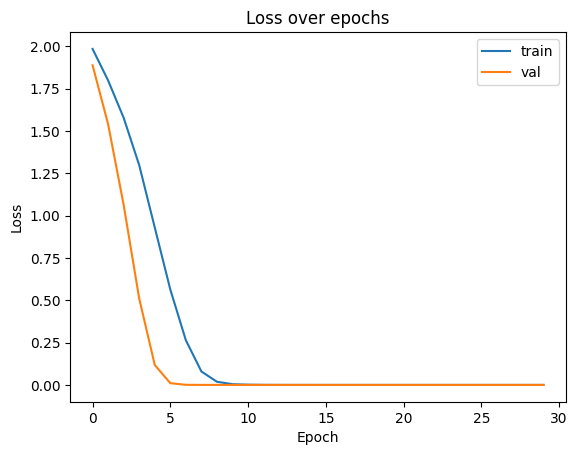

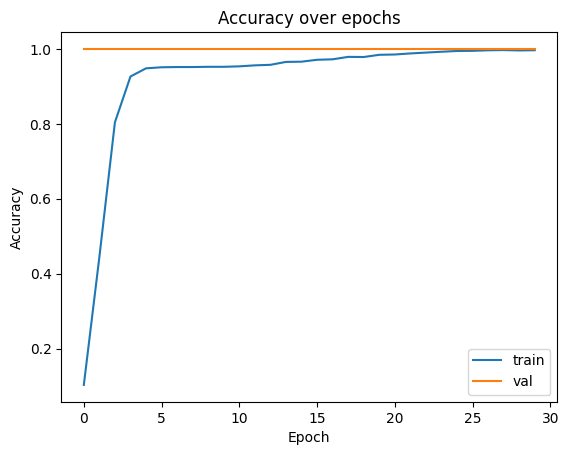

In [17]:
# ==========================================
# 8) Plot loss & accuracy
# ==========================================
hist = history.history

plt.figure()
plt.plot(hist['loss'], label='train')
plt.plot(hist['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss over epochs'); plt.legend(); plt.show()

plt.figure()
plt.plot(hist['accuracy'], label='train')
plt.plot(hist['val_accuracy'], label='val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy over epochs'); plt.legend(); plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
=== Q8 Classification Report ===
              precision    recall  f1-score   support

           L     0.9057    1.0000    0.9505       634
           B     0.0000    0.0000    0.0000         6
           E     0.0000    0.0000    0.0000         9
           G     0.0000    0.0000    0.0000         7
           I     0.0000    0.0000    0.0000         0
           H     0.0000    0.0000    0.0000        16
           S     0.0000    0.0000    0.0000        17
           T     0.0000    0.0000    0.0000        11

    accuracy                         0.9057       700
   macro avg     0.1132    0.1250    0.1188       700
weighted avg     0.8203    0.9057    0.8609       700



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

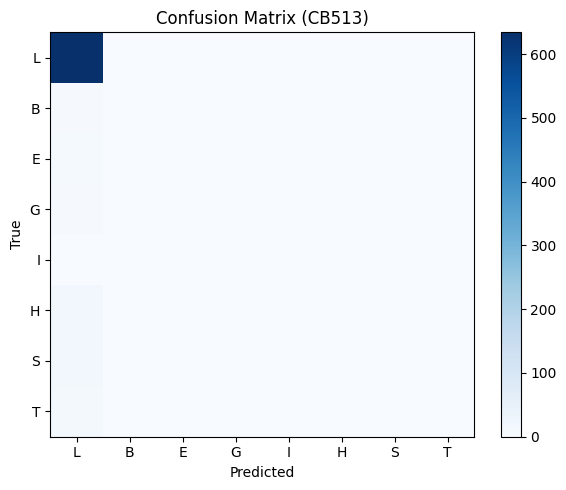

In [18]:
# ==========================================
# 9) Evaluate on test set (CB513)
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
preds = model.predict(X_test, batch_size=16)

# Flatten masks and filter padded positions
mask_flat = (M_test.reshape(-1) > 0.5)

# Get predicted and true labels (argmax over Q8 classes)
pred_labels = preds.argmax(-1).reshape(-1)[mask_flat]
true_labels = Y_test.argmax(-1).reshape(-1)[mask_flat]

# Q8 classes
class_names = ['L','B','E','G','I','H','S','T']
labels = list(range(8))  # numeric labels 0-7

# Classification report
print("=== Q8 Classification Report ===")
print(classification_report(
    true_labels,
    pred_labels,
    labels=labels,           # ensures correct mapping
    target_names=class_names,
    digits=4
))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=labels)
plt.figure(figsize=(6,5))
plt.imshow(cm, aspect='auto', cmap='Blues')
plt.title('Confusion Matrix (CB513)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.xticks(np.arange(8), class_names)
plt.yticks(np.arange(8), class_names)
plt.colorbar(); plt.tight_layout(); plt.show()


In [19]:
import os, glob, shutil
import imageio
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks
from IPython.display import display, HTML

class WeightGIFCallback(callbacks.Callback):
    def __init__(self, layers_to_track=None, outdir='outputs/gifs', fps=2, display_gif=True):
        super().__init__()
        self.layers_to_track = layers_to_track
        self.outdir = outdir
        self.fps = fps
        self.display_gif = display_gif
        os.makedirs(outdir, exist_ok=True)

    def on_train_begin(self, logs=None):
        if self.layers_to_track is None:
            self.layers_to_track = [l.name for l in self.model.layers if l.weights]
        print('Tracking layers:', self.layers_to_track)
        for ln in self.layers_to_track:
            layer_dir = os.path.join(self.outdir, ln)
            if os.path.exists(layer_dir):
                shutil.rmtree(layer_dir)
            os.makedirs(layer_dir, exist_ok=True)

    def _plot_weight(self, w, title, save_path):
        plt.figure(figsize=(5,4))
        wflat = w.flatten()
        if w.ndim >= 2 and w.shape[0]*w.shape[1] <= 200_000:
            mat = w if w.ndim == 2 else w.reshape(w.shape[0], -1)
            plt.imshow(mat, aspect='auto', cmap='coolwarm')
            plt.colorbar()
        else:
            plt.hist(wflat, bins=50, color='skyblue')
        plt.title(title)
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()

    def on_epoch_end(self, epoch, logs=None):
        for layer in self.model.layers:
            if layer.name not in self.layers_to_track:
                continue
            weights = layer.get_weights()
            if not weights:
                continue
            for i, w in enumerate(weights[:2]):
                frame_path = os.path.join(self.outdir, layer.name, f'ep{epoch:03d}_w{i}.png')
                self._plot_weight(w, f'{layer.name} / w{i} / epoch {epoch+1}', frame_path)

    def on_train_end(self, logs=None):
        for layer_name in self.layers_to_track:
            layer_dir = os.path.join(self.outdir, layer_name)
            by_weight = {}
            for p in sorted(glob.glob(os.path.join(layer_dir, 'ep*_w*.png'))):
                wi = int(p.split('_w')[-1].split('.png')[0])
                by_weight.setdefault(wi, []).append(p)
            for wi, frames in by_weight.items():
                images = [imageio.v2.imread(f) for f in frames]
                gif_path = os.path.join(self.outdir, f'{layer_name}_w{wi}.gif')
                imageio.mimsave(gif_path, images, fps=self.fps)
                print('Saved GIF:', gif_path)
                if self.display_gif:
                    display(HTML(f'<h4>{layer_name} / w{wi}</h4><img src="{gif_path}" width="600">'))

# Usage
weight_gif_cb = WeightGIFCallback(
    layers_to_track=['conv1', 'bilstm1', 'conv2', 'tdense1', 'q8_logits'],
    fps=2,
    display_gif=True
)

# Then add `weight_gif_cb` to your model.fit() callbacks:
model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[weight_gif_cb])


Tracking layers: ['conv1', 'bilstm1', 'conv2', 'tdense1', 'q8_logits']
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.9978 - loss: 1.2872e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9973 - loss: 1.1374e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9971 - loss: 1.1582e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9988 - loss: 1.1982e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9986 - loss: 1.1523e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9986 - loss: 1.2268e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9990 - loss: 1.1369e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 8/30
1

In [21]:
import os
import matplotlib.pyplot as plt
import json
import numpy as np

# Ensure directories exist
os.makedirs('outputs/figures', exist_ok=True)

# 1️⃣ Save Loss & Accuracy curves if not already saved
try:
    with open('outputs/training_history.json', 'r') as f:
        history = json.load(f)
    hist = history

    # Loss curve
    plt.figure()
    plt.plot(hist['loss'], label='train')
    plt.plot(hist['val_loss'], label='val')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss over epochs'); plt.legend()
    plt.tight_layout()
    plt.savefig('outputs/figures/loss_curve.png')
    plt.close()
    print("Saved: outputs/figures/loss_curve.png")

    # Accuracy curve
    plt.figure()
    plt.plot(hist['accuracy'], label='train')
    plt.plot(hist['val_accuracy'], label='val')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy over epochs'); plt.legend()
    plt.tight_layout()
    plt.savefig('outputs/figures/accuracy_curve.png')
    plt.close()
    print("Saved: outputs/figures/accuracy_curve.png")

except Exception as e:
    print("Error saving loss/accuracy curves:", e)

# 2️⃣ Save Confusion Matrix (CB513)
try:
    from sklearn.metrics import confusion_matrix
    # Make sure pred_labels and true_labels exist from your evaluation step
    labels = np.unique(true_labels)
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)
    class_names = ['L','B','E','G','I','H','S','T']

    plt.figure(figsize=(6,5))
    plt.imshow(cm, aspect='auto')
    plt.title('Confusion Matrix (CB513)')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.xticks(np.arange(len(class_names)), class_names)
    plt.yticks(np.arange(len(class_names)), class_names)
    plt.colorbar()
    plt.tight_layout()
    plt.savefig('outputs/figures/confusion_matrix.png')
    plt.close()
    print("Saved: outputs/figures/confusion_matrix.png")

except Exception as e:
    print("Error saving confusion matrix:", e)

# 3️⃣ Save Model Diagram
try:
    import tensorflow as tf
    tf.keras.utils.plot_model(model, show_shapes=True, to_file='outputs/figures/model.png')
    print("Saved: outputs/figures/model.png")
except Exception as e:
    print("Error saving model diagram:", e)


Error saving loss/accuracy curves: [Errno 2] No such file or directory: 'outputs/training_history.json'
Saved: outputs/figures/confusion_matrix.png
Saved: outputs/figures/model.png
